In [2]:
import os, sys
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from data_loader import *
import model_tcn
from model_tcn import *
import matplotlib.pyplot as plt
import wandb

if torch.cuda.is_available():
  dev = "cuda:1"
else:
  dev = "cpu"
device = torch.device(dev)

In [3]:
### 데이터 읽기 ###
file_name = './data/df.csv'
data = pd.read_csv(file_name)
data['날짜'] = pd.to_datetime(data['날짜'])
data.set_index('날짜', inplace=True)
len(data)

5634

In [4]:
data.drop('저가', axis=1, inplace=True)
data.drop('고가', axis=1, inplace=True)
data

,종가,MA-5,MA-15,EMA-5,EMA-15,RSI
날짜,,,,,,
2000-01-24,5700,5936.0,5828.666667,5865.593036,5896.493569,39.153439
2000-01-25,5440,5804.0,5784.000000,5723.728691,5839.431873,45.679012
2000-01-26,5480,5708.0,5777.333333,5642.485794,5794.502889,45.679012
2000-01-27,5520,5604.0,5770.666667,5601.657196,5760.190028,49.367089
2000-01-28,5820,5592.0,5789.333333,5674.438131,5767.666274,51.515152
...,...,...,...,...,...,...
2023-09-21,68900,70100.0,70533.333333,69790.404298,69914.872558,35.616438
2023-09-22,68800,69460.0,70386.666667,69460.269532,69775.513488,33.333333
2023-09-25,69400,69300.0,70266.666667,69440.179688,69728.574302,41.095890


In [6]:
### 로그리턴으로 변환 ###
#data['시가'] = np.log(data['시가'] / data['시가'].shift(1))
#data['고가'] = np.log(data['고가'] / data['고가'].shift(1))
#data['저가'] = np.log(data['저가'] / data['저가'].shift(1))
data['종가'] = np.log(data['종가'] / data['종가'].shift(1))
data['MA-5'] = np.log(data['MA-5'] / data['MA-5'].shift(1))
data['MA-15'] = np.log(data['MA-15'] / data['MA-15'].shift(1))
data['EMA-5'] = np.log(data['EMA-5'] / data['EMA-5'].shift(1))
data['EMA-15'] = np.log(data['EMA-15'] / data['EMA-15'].shift(1))
data = data.iloc[1:]
data

,종가,MA-5,MA-15,EMA-5,EMA-15,RSI
날짜,,,,,,
2000-01-25,-0.046687,-0.022488,-0.007693,-0.024483,-0.009724,45.679012
2000-01-26,0.007326,-0.016679,-0.001153,-0.014296,-0.007724,45.679012
2000-01-27,0.007273,-0.018388,-0.001155,-0.007262,-0.005939,49.367089
2000-01-28,0.052922,-0.002144,0.003230,0.012909,0.001297,51.515152
2000-01-31,-0.042111,-0.004301,-0.002190,-0.005563,-0.004075,44.973545
...,...,...,...,...,...,...
2023-09-21,-0.010108,-0.007957,0.001892,-0.006359,-0.002072,35.616438
2023-09-22,-0.001452,-0.009172,-0.002082,-0.004742,-0.001995,33.333333
2023-09-25,0.008683,-0.002306,-0.001706,-0.000289,-0.000673,41.095890


In [5]:
### 데이터 전처리 ###c
seq_len = 127
# window = {5, 7}
# target = {MA-7 or EMA-7}
window = 10
price = data.to_numpy()
idx = data.index
print(price.shape)

(5633, 8)


In [6]:
### train / test 분리 ###
train_size = int(len(price) * 0.6)
val_size = int(len(price) * 0.2)

train_X = price[ : train_size]
val_X = price[train_size : train_size + val_size]
test_X = price[train_size + val_size :]

train_idx = idx[seq_len + window : train_size]
val_idx = idx[train_size + seq_len + window : train_size + val_size]
test_idx = idx[train_size + val_size + seq_len + window : ]

print("train length : ", len(train_X), "test length : ", len(test_X))
print(len(test_idx))

train length :  3379 test length :  1128
991


In [7]:
### 데이터 스케일링 ###
mean = np.mean(train_X, axis=0)
std = np.std(train_X, axis=0)

train_scaled = (train_X - mean) / std
val_scaled = (val_X - mean) / std
test_scaled = (test_X - mean)/ std

print(train_scaled.shape)
print(val_scaled.shape)
print(test_scaled.shape)

(3379, 8)
(1126, 8)
(1128, 8)


In [8]:
### 하이퍼파라미터 ###
num_epochs = 100
batch_size = 256
clip= 1.0
lr = 0.0001
receptive_field_size = 127

wandb.init(
   project='TCN',
   config = {
      "learning_rate": lr,
      "epochs": num_epochs,
      "batch_size": batch_size
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [9]:
### Load the data ###
dataset_train = Loader32(train_scaled, seq_len, window)
dataset_val = Loader32(val_scaled, seq_len, window)
dataset_test = Loader32(test_scaled, seq_len, window)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
model_path = "best_model.pth"
### 모델 학습 ###
def train(train_dataloader, val_dataloader, model, loss_fn, optimizer, num_epochs):
    best_val_loss = float('inf')  # 초기 검증 손실 값을 무한대로 설정

    for epoch in tqdm(range(num_epochs), leave=True):
        ## 훈련단계
        model.train()
        total_train_loss = 0
        for idx, (data, target) in enumerate(train_dataloader, 0):
            if data == None or target == None:
                continue
            optimizer.zero_grad()
            pred = model(data)        
            loss = loss_fn(pred, target.reshape(-1, 1))
            loss.backward()
            optimizer.step()
            for dp in model.parameters():
                dp.data.clamp_(-clip, clip)
            total_train_loss += loss.item()

        ## 검증단계
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for idx, (data, target) in enumerate(val_dataloader, 0):
                val_pred = model(data)
                val_loss = loss_fn(val_pred, target.reshape(-1, 1))
                total_val_loss += val_loss.item()

        # 검증 손실이 더 작으면 모델 저장
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            print('모델저장 epoch : ', epoch)
            torch.save(model.state_dict(), model_path)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {total_train_loss}, Validation Loss: {total_val_loss}")
        wandb.log({"Train Loss": total_train_loss, "Validation Loss": total_val_loss})
    

In [11]:
### TCN 모델 초기화 및 정의 ###
input_channels=8
output_size=1
kernel_size=2
dropout=0.05
model = TCN(input_channels, output_size, kernel_size, dropout)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
train(dataloader_train, dataloader_val, model, loss_fn, optimizer, num_epochs)

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:01<02:10,  1.32s/it]

모델저장 epoch :  0
Epoch [1/100], Train Loss: 541.1631050109863, Validation Loss: 75.22408866882324


  2%|▏         | 2/100 [00:02<01:59,  1.22s/it]

모델저장 epoch :  1
Epoch [2/100], Train Loss: 539.905460357666, Validation Loss: 74.86724281311035


  3%|▎         | 3/100 [00:03<01:56,  1.20s/it]

모델저장 epoch :  2
Epoch [3/100], Train Loss: 540.7362937927246, Validation Loss: 74.16666030883789


  4%|▍         | 4/100 [00:04<01:53,  1.18s/it]

모델저장 epoch :  3
Epoch [4/100], Train Loss: 534.2496871948242, Validation Loss: 73.79691886901855


  5%|▌         | 5/100 [00:05<01:51,  1.17s/it]

Epoch [5/100], Train Loss: 532.0310516357422, Validation Loss: 73.90165615081787


  6%|▌         | 6/100 [00:07<01:49,  1.17s/it]

모델저장 epoch :  5
Epoch [6/100], Train Loss: 524.557149887085, Validation Loss: 73.28437042236328


  7%|▋         | 7/100 [00:08<01:49,  1.18s/it]

모델저장 epoch :  6
Epoch [7/100], Train Loss: 520.8625717163086, Validation Loss: 72.3209457397461


  8%|▊         | 8/100 [00:09<01:48,  1.18s/it]

모델저장 epoch :  7
Epoch [8/100], Train Loss: 513.3775253295898, Validation Loss: 70.99824142456055


  9%|▉         | 9/100 [00:10<01:46,  1.17s/it]

모델저장 epoch :  8
Epoch [9/100], Train Loss: 503.3162307739258, Validation Loss: 70.06474590301514


 10%|█         | 10/100 [00:11<01:45,  1.17s/it]

Epoch [10/100], Train Loss: 485.2127456665039, Validation Loss: 70.13321685791016


 11%|█         | 11/100 [00:12<01:43,  1.17s/it]

Epoch [11/100], Train Loss: 475.0032196044922, Validation Loss: 70.19786834716797


 12%|█▏        | 12/100 [00:14<01:42,  1.16s/it]

모델저장 epoch :  11
Epoch [12/100], Train Loss: 459.54133796691895, Validation Loss: 69.54070472717285


 13%|█▎        | 13/100 [00:15<01:40,  1.16s/it]

Epoch [13/100], Train Loss: 452.8898696899414, Validation Loss: 69.65399742126465


 14%|█▍        | 14/100 [00:16<01:38,  1.15s/it]

모델저장 epoch :  13
Epoch [14/100], Train Loss: 449.55392837524414, Validation Loss: 68.48469829559326


 15%|█▌        | 15/100 [00:17<01:38,  1.16s/it]

모델저장 epoch :  14
Epoch [15/100], Train Loss: 444.61694717407227, Validation Loss: 68.05121803283691


 16%|█▌        | 16/100 [00:18<01:37,  1.17s/it]

모델저장 epoch :  15
Epoch [16/100], Train Loss: 438.0326747894287, Validation Loss: 67.34691524505615


 17%|█▋        | 17/100 [00:19<01:37,  1.18s/it]

Epoch [17/100], Train Loss: 434.7349090576172, Validation Loss: 68.19131660461426


 18%|█▊        | 18/100 [00:21<01:39,  1.21s/it]

모델저장 epoch :  17
Epoch [18/100], Train Loss: 436.2828826904297, Validation Loss: 67.3166332244873


 19%|█▉        | 19/100 [00:22<01:39,  1.23s/it]

Epoch [19/100], Train Loss: 429.30593490600586, Validation Loss: 67.71657180786133


 20%|██        | 20/100 [00:23<01:40,  1.25s/it]

Epoch [20/100], Train Loss: 426.3027458190918, Validation Loss: 67.8675365447998


 21%|██        | 21/100 [00:25<01:40,  1.27s/it]

Epoch [21/100], Train Loss: 424.36292457580566, Validation Loss: 67.83412551879883


 22%|██▏       | 22/100 [00:26<01:39,  1.27s/it]

Epoch [22/100], Train Loss: 421.26849365234375, Validation Loss: 67.63135242462158


 23%|██▎       | 23/100 [00:27<01:37,  1.27s/it]

Epoch [23/100], Train Loss: 421.01368713378906, Validation Loss: 68.42770481109619


 24%|██▍       | 24/100 [00:28<01:35,  1.26s/it]

Epoch [24/100], Train Loss: 415.82975578308105, Validation Loss: 68.36457252502441


 25%|██▌       | 25/100 [00:30<01:32,  1.24s/it]

Epoch [25/100], Train Loss: 413.79922676086426, Validation Loss: 68.47929763793945


 26%|██▌       | 26/100 [00:31<01:31,  1.24s/it]

Epoch [26/100], Train Loss: 407.936279296875, Validation Loss: 69.7067756652832


 27%|██▋       | 27/100 [00:32<01:31,  1.25s/it]

Epoch [27/100], Train Loss: 402.749547958374, Validation Loss: 69.99381446838379


 28%|██▊       | 28/100 [00:33<01:30,  1.26s/it]

Epoch [28/100], Train Loss: 402.848352432251, Validation Loss: 70.65093326568604


 29%|██▉       | 29/100 [00:35<01:29,  1.25s/it]

Epoch [29/100], Train Loss: 403.461275100708, Validation Loss: 70.30187034606934


 30%|███       | 30/100 [00:36<01:27,  1.25s/it]

Epoch [30/100], Train Loss: 403.7615966796875, Validation Loss: 71.39038944244385


 31%|███       | 31/100 [00:37<01:25,  1.24s/it]

Epoch [31/100], Train Loss: 394.37440490722656, Validation Loss: 72.02621650695801


 32%|███▏      | 32/100 [00:38<01:24,  1.24s/it]

Epoch [32/100], Train Loss: 390.86997413635254, Validation Loss: 72.65498733520508


 33%|███▎      | 33/100 [00:40<01:23,  1.25s/it]

Epoch [33/100], Train Loss: 387.88673973083496, Validation Loss: 72.9882869720459


 34%|███▍      | 34/100 [00:41<01:22,  1.25s/it]

Epoch [34/100], Train Loss: 387.2346591949463, Validation Loss: 74.34272766113281


 35%|███▌      | 35/100 [00:42<01:20,  1.24s/it]

Epoch [35/100], Train Loss: 381.17563247680664, Validation Loss: 74.40959167480469


 36%|███▌      | 36/100 [00:43<01:19,  1.24s/it]

Epoch [36/100], Train Loss: 376.6806831359863, Validation Loss: 74.40402412414551


 37%|███▋      | 37/100 [00:45<01:19,  1.26s/it]

Epoch [37/100], Train Loss: 370.4851875305176, Validation Loss: 75.92694091796875


 38%|███▊      | 38/100 [00:46<01:16,  1.24s/it]

Epoch [38/100], Train Loss: 370.6870937347412, Validation Loss: 75.2715015411377


 39%|███▉      | 39/100 [00:47<01:14,  1.23s/it]

Epoch [39/100], Train Loss: 356.42938804626465, Validation Loss: 76.05393600463867


 40%|████      | 40/100 [00:48<01:13,  1.22s/it]

Epoch [40/100], Train Loss: 358.61624336242676, Validation Loss: 77.85067749023438


 41%|████      | 41/100 [00:49<01:12,  1.22s/it]

Epoch [41/100], Train Loss: 354.13255310058594, Validation Loss: 77.69591522216797


 42%|████▏     | 42/100 [00:51<01:10,  1.22s/it]

Epoch [42/100], Train Loss: 347.4064083099365, Validation Loss: 78.04032516479492


 43%|████▎     | 43/100 [00:52<01:09,  1.22s/it]

Epoch [43/100], Train Loss: 344.1363048553467, Validation Loss: 77.93234825134277


 44%|████▍     | 44/100 [00:53<01:07,  1.21s/it]

Epoch [44/100], Train Loss: 335.5996799468994, Validation Loss: 82.43615913391113


 45%|████▌     | 45/100 [00:54<01:05,  1.19s/it]

Epoch [45/100], Train Loss: 335.0571708679199, Validation Loss: 80.23328971862793


 46%|████▌     | 46/100 [00:55<01:03,  1.18s/it]

Epoch [46/100], Train Loss: 324.1080551147461, Validation Loss: 80.88249778747559


 47%|████▋     | 47/100 [00:57<01:03,  1.19s/it]

Epoch [47/100], Train Loss: 316.6682186126709, Validation Loss: 82.04390144348145


 48%|████▊     | 48/100 [00:58<01:01,  1.19s/it]

Epoch [48/100], Train Loss: 304.2769031524658, Validation Loss: 83.81711387634277


 49%|████▉     | 49/100 [00:59<01:00,  1.19s/it]

Epoch [49/100], Train Loss: 297.7834949493408, Validation Loss: 83.37975120544434


 50%|█████     | 50/100 [01:00<00:59,  1.19s/it]

Epoch [50/100], Train Loss: 291.7579936981201, Validation Loss: 85.7249813079834


 51%|█████     | 51/100 [01:01<00:58,  1.18s/it]

Epoch [51/100], Train Loss: 281.78069496154785, Validation Loss: 87.27019309997559


 52%|█████▏    | 52/100 [01:03<00:56,  1.19s/it]

Epoch [52/100], Train Loss: 274.52453804016113, Validation Loss: 86.54519844055176


 53%|█████▎    | 53/100 [01:04<00:55,  1.19s/it]

Epoch [53/100], Train Loss: 263.581729888916, Validation Loss: 87.8925666809082


 54%|█████▍    | 54/100 [01:05<00:54,  1.19s/it]

Epoch [54/100], Train Loss: 256.42834281921387, Validation Loss: 89.1982364654541


 55%|█████▌    | 55/100 [01:06<00:53,  1.19s/it]

Epoch [55/100], Train Loss: 251.24146842956543, Validation Loss: 90.68285179138184


 56%|█████▌    | 56/100 [01:07<00:52,  1.20s/it]

Epoch [56/100], Train Loss: 242.00017642974854, Validation Loss: 90.89980697631836


 57%|█████▋    | 57/100 [01:09<00:51,  1.21s/it]

Epoch [57/100], Train Loss: 243.72954750061035, Validation Loss: 92.49744033813477


 58%|█████▊    | 58/100 [01:10<00:50,  1.21s/it]

Epoch [58/100], Train Loss: 236.16260433197021, Validation Loss: 91.86967468261719


 59%|█████▉    | 59/100 [01:11<00:49,  1.20s/it]

Epoch [59/100], Train Loss: 231.32350540161133, Validation Loss: 92.78483581542969


 60%|██████    | 60/100 [01:12<00:47,  1.19s/it]

Epoch [60/100], Train Loss: 221.91864776611328, Validation Loss: 94.96625137329102


 61%|██████    | 61/100 [01:13<00:46,  1.19s/it]

Epoch [61/100], Train Loss: 216.59635543823242, Validation Loss: 96.81020164489746


 62%|██████▏   | 62/100 [01:15<00:45,  1.19s/it]

Epoch [62/100], Train Loss: 212.4706048965454, Validation Loss: 95.33735847473145


 63%|██████▎   | 63/100 [01:16<00:44,  1.20s/it]

Epoch [63/100], Train Loss: 200.2731533050537, Validation Loss: 96.39355850219727


 64%|██████▍   | 64/100 [01:17<00:43,  1.21s/it]

Epoch [64/100], Train Loss: 198.85087394714355, Validation Loss: 95.79146003723145


 65%|██████▌   | 65/100 [01:18<00:42,  1.21s/it]

Epoch [65/100], Train Loss: 201.26158809661865, Validation Loss: 95.40951728820801


 66%|██████▌   | 66/100 [01:19<00:41,  1.21s/it]

Epoch [66/100], Train Loss: 187.89569091796875, Validation Loss: 99.21177864074707


 67%|██████▋   | 67/100 [01:21<00:39,  1.20s/it]

Epoch [67/100], Train Loss: 185.62390995025635, Validation Loss: 99.62369728088379


 68%|██████▊   | 68/100 [01:22<00:38,  1.20s/it]

Epoch [68/100], Train Loss: 183.14201641082764, Validation Loss: 99.51156616210938


 69%|██████▉   | 69/100 [01:23<00:36,  1.19s/it]

Epoch [69/100], Train Loss: 190.38360500335693, Validation Loss: 98.92316818237305


 70%|███████   | 70/100 [01:24<00:35,  1.19s/it]

Epoch [70/100], Train Loss: 186.15459632873535, Validation Loss: 98.30918884277344


 71%|███████   | 71/100 [01:25<00:34,  1.20s/it]

Epoch [71/100], Train Loss: 179.96118068695068, Validation Loss: 101.17209243774414


 72%|███████▏  | 72/100 [01:27<00:33,  1.21s/it]

Epoch [72/100], Train Loss: 174.78264999389648, Validation Loss: 100.05517959594727


 73%|███████▎  | 73/100 [01:28<00:32,  1.20s/it]

Epoch [73/100], Train Loss: 164.73669052124023, Validation Loss: 101.6069221496582


 74%|███████▍  | 74/100 [01:29<00:30,  1.18s/it]

Epoch [74/100], Train Loss: 165.09457206726074, Validation Loss: 100.83175277709961


 75%|███████▌  | 75/100 [01:30<00:29,  1.18s/it]

Epoch [75/100], Train Loss: 163.09984302520752, Validation Loss: 101.33768081665039


 76%|███████▌  | 76/100 [01:31<00:28,  1.17s/it]

Epoch [76/100], Train Loss: 162.5276288986206, Validation Loss: 101.63912200927734


 77%|███████▋  | 77/100 [01:32<00:27,  1.18s/it]

Epoch [77/100], Train Loss: 161.52504348754883, Validation Loss: 102.61859321594238


 78%|███████▊  | 78/100 [01:34<00:26,  1.19s/it]

Epoch [78/100], Train Loss: 153.41016578674316, Validation Loss: 103.77165794372559


 79%|███████▉  | 79/100 [01:35<00:25,  1.20s/it]

Epoch [79/100], Train Loss: 153.8588466644287, Validation Loss: 105.82989311218262


 80%|████████  | 80/100 [01:36<00:23,  1.19s/it]

Epoch [80/100], Train Loss: 154.1316499710083, Validation Loss: 103.31721687316895


 81%|████████  | 81/100 [01:37<00:22,  1.19s/it]

Epoch [81/100], Train Loss: 153.33992862701416, Validation Loss: 106.81170463562012


 82%|████████▏ | 82/100 [01:38<00:21,  1.18s/it]

Epoch [82/100], Train Loss: 149.93661212921143, Validation Loss: 106.1543083190918


 83%|████████▎ | 83/100 [01:40<00:20,  1.18s/it]

Epoch [83/100], Train Loss: 146.06520462036133, Validation Loss: 104.24738693237305


 84%|████████▍ | 84/100 [01:41<00:19,  1.20s/it]

Epoch [84/100], Train Loss: 145.37327098846436, Validation Loss: 104.39962196350098


 85%|████████▌ | 85/100 [01:42<00:18,  1.20s/it]

Epoch [85/100], Train Loss: 140.1786527633667, Validation Loss: 106.12198448181152


 86%|████████▌ | 86/100 [01:43<00:16,  1.20s/it]

Epoch [86/100], Train Loss: 139.0915994644165, Validation Loss: 106.85831832885742


 87%|████████▋ | 87/100 [01:44<00:15,  1.20s/it]

Epoch [87/100], Train Loss: 139.66291332244873, Validation Loss: 104.7180118560791


 88%|████████▊ | 88/100 [01:46<00:14,  1.20s/it]

Epoch [88/100], Train Loss: 146.89755249023438, Validation Loss: 105.59389686584473


 89%|████████▉ | 89/100 [01:47<00:13,  1.20s/it]

Epoch [89/100], Train Loss: 137.4032154083252, Validation Loss: 105.52326774597168


 90%|█████████ | 90/100 [01:48<00:11,  1.20s/it]

Epoch [90/100], Train Loss: 131.70782661437988, Validation Loss: 106.65189361572266


 91%|█████████ | 91/100 [01:49<00:10,  1.18s/it]

Epoch [91/100], Train Loss: 131.60848236083984, Validation Loss: 108.42189979553223


 92%|█████████▏| 92/100 [01:50<00:09,  1.19s/it]

Epoch [92/100], Train Loss: 134.93960094451904, Validation Loss: 111.96533584594727


 93%|█████████▎| 93/100 [01:52<00:08,  1.20s/it]

Epoch [93/100], Train Loss: 127.45014095306396, Validation Loss: 110.89164543151855


 94%|█████████▍| 94/100 [01:53<00:07,  1.22s/it]

Epoch [94/100], Train Loss: 129.5778522491455, Validation Loss: 108.8081283569336


 95%|█████████▌| 95/100 [01:54<00:06,  1.22s/it]

Epoch [95/100], Train Loss: 121.51156902313232, Validation Loss: 110.7491512298584


 96%|█████████▌| 96/100 [01:55<00:04,  1.22s/it]

Epoch [96/100], Train Loss: 127.23223972320557, Validation Loss: 108.60307312011719


 97%|█████████▋| 97/100 [01:56<00:03,  1.22s/it]

Epoch [97/100], Train Loss: 119.17849731445312, Validation Loss: 110.09998321533203


 98%|█████████▊| 98/100 [01:58<00:02,  1.22s/it]

Epoch [98/100], Train Loss: 117.90166997909546, Validation Loss: 112.60974502563477


 99%|█████████▉| 99/100 [01:59<00:01,  1.22s/it]

Epoch [99/100], Train Loss: 121.30226135253906, Validation Loss: 112.30259895324707


100%|██████████| 100/100 [02:00<00:00,  1.21s/it]

Epoch [100/100], Train Loss: 119.78225708007812, Validation Loss: 109.58991813659668


In [12]:
### 모델 테스트 ###

model.load_state_dict(torch.load(model_path))

pred_y = []     # 예측값
target_y = []   # 실제값

with torch.no_grad():
    model.eval()
    for idx, (data, target) in enumerate(dataloader_test, 0):
        if data == None or target == None:
            continue
        pred = model(data)
        pred_y.append(pred)
        target_y.append(target)

pred_y = torch.cat(pred_y, dim=0).numpy()
target_y = torch.cat(target_y, dim=0).numpy()

### inverse 스케일링
pred_y = (pred_y.reshape(-1) * std[3]) + mean[3]
target_y = (target_y * std[3]) + mean[3]


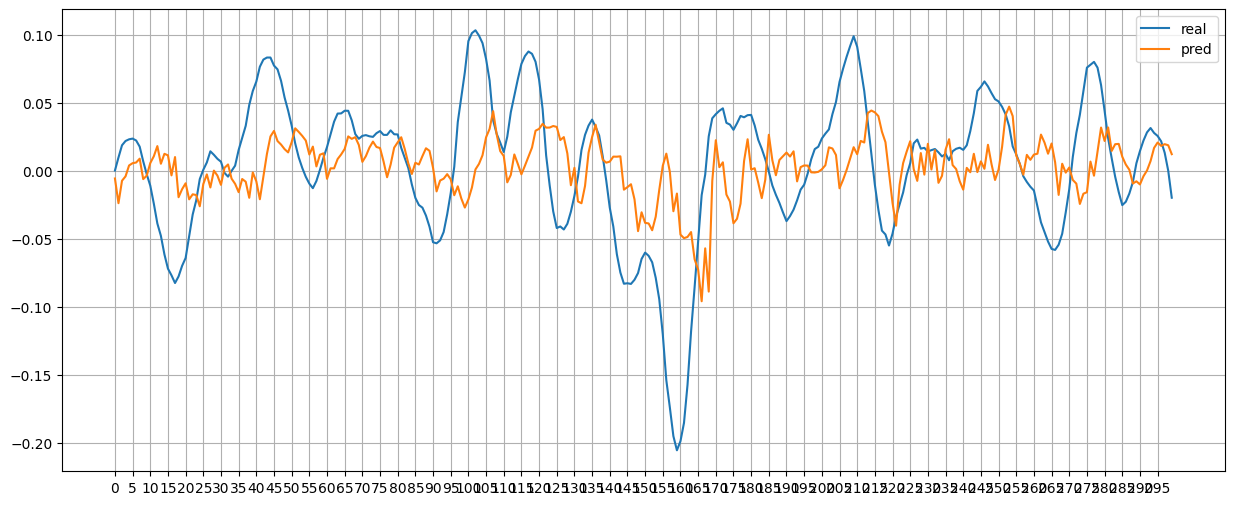

In [13]:

# 가격 데이터를 볼 경우 plot

from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(15,6))


plt.plot(target_y[:300], label='real')
plt.plot(pred_y[:300], label='pred')
#plt.plot(pred_y + target_y[0] - pred_y[0], label='pred')  # 첫 번째 시계열 데이터 플롯

plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 300, 5))  # 40 단위로 레이블 표시

plt.show()


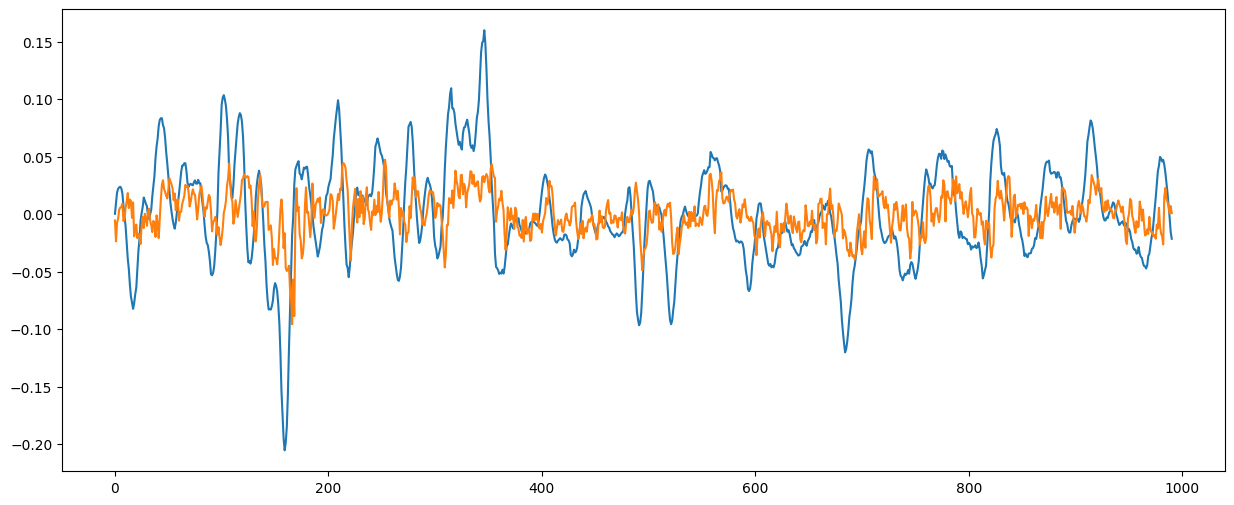

In [14]:
# 로그리턴일 경우
pred_y
target_y
plt.figure(figsize=(15,6))

plt.plot(target_y, label='real')
plt.plot(pred_y, label='pred')
